# Burned Home Identifier


Drones are increasingly being flown over wildfire affected areas in California to assist in rehabilitation efforts and identify whether or not it is safe for people to return to their homes. In most cases however, this identification is a largely manual process with human operators going through a large number of images and making judgement calls. Considering how important time is as a factor in rescue and rehabiliation operations, we have created a system that can identify burned homes and along with location information coorelated with the image, help first responders in their tasks. This speeds up the operation and allows for valuable human resources to be reassigned to the rehabilitation tasks. 

This model is trained specifically for high resolution drone-captured/aerial images and not phone/on-ground imagery. For accurate results, use those for testing. The model has been built using Fastai, which is built on PyTorch.

Since drone images for such use cases are very limited in number, we have used data augmentation techniques to artifically enhance the amount of data the model trains on, in order for it to generalize better. We have tested the model on multiple validation images that we were able to gather. 



In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
#bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We use a dataset of drone captured images of suburban homes that we have collected and cleaned.

In [0]:
Path.ls = lambda x: list(x.iterdir())
img_dir = Path(root_dir)
print(img_dir.ls())
img_path = img_dir.ls()[24]; img_path

[PosixPath('/content/gdrive/My Drive/cv final.pdf'), PosixPath('/content/gdrive/My Drive/GameForBlinds (1).docx'), PosixPath('/content/gdrive/My Drive/GameForBlinds (1).docx.gdoc'), PosixPath('/content/gdrive/My Drive/scanned document0002.PDF'), PosixPath('/content/gdrive/My Drive/Project Proposal.gdoc'), PosixPath('/content/gdrive/My Drive/Project Communicate Observation Report.pdf'), PosixPath('/content/gdrive/My Drive/Project Communicate Literature Review.pdf'), PosixPath('/content/gdrive/My Drive/Copy of Project Communicate Literature Review.pdf'), PosixPath('/content/gdrive/My Drive/testcase5-nestingFunctions.txt'), PosixPath('/content/gdrive/My Drive/testcase5-nestingFunctions.txt.gdoc'), PosixPath('/content/gdrive/My Drive/ABSTRACT(template).pdf'), PosixPath('/content/gdrive/My Drive/Web Content - Project Communicate.gdoc'), PosixPath('/content/gdrive/My Drive/Project Connect Vision.gdoc'), PosixPath('/content/gdrive/My Drive/Time Table.gdoc'), PosixPath('/content/gdrive/My Driv

PosixPath('/content/gdrive/My Drive/homes')

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
#adding transforms for better generalizations
np.random.seed(42)
data = ImageDataBunch.from_folder(img_path, bs=16,ds_tfms=tfms, size=64)


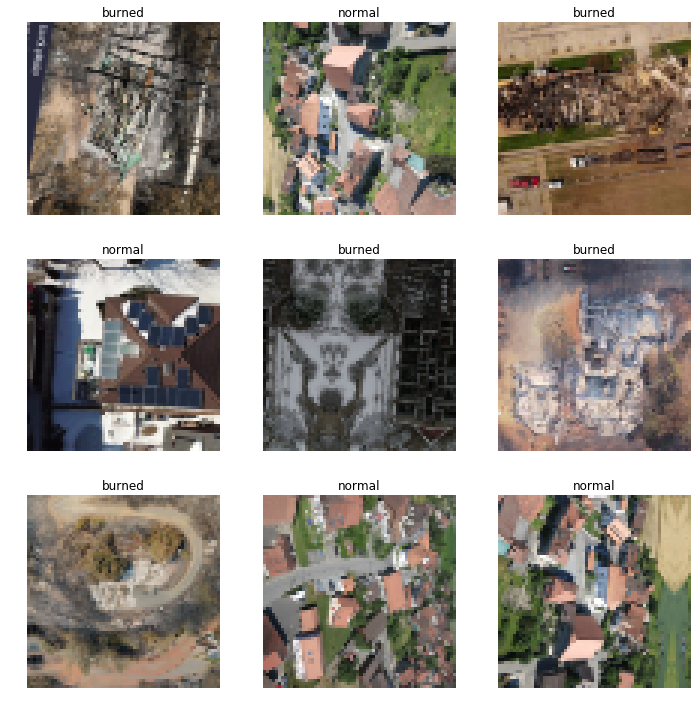

In [0]:
data.show_batch(rows=3, figsize=(10,10))

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. We have placed our data in  folders of the two categories with training and validation sets.

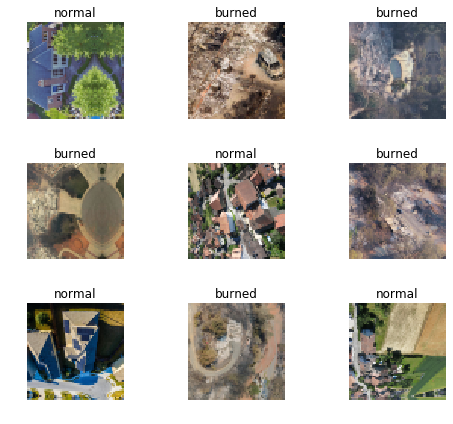

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['burned', 'normal']


(2, 2)

## Training: resnet50

We first trained a resnet34 model which gave us an accuracy of 95%. Now, instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers.) 

Basically, resnet50 usually performs better because it is a deeper network with more parameters. We achieved a higher performance here, despite running the risk of overfitting and hence have chosen to stick with this model. To help it along, we use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_folder(img_path,ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


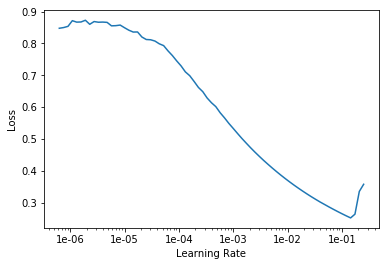

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.836919,0.475084,0.150000,00:15
1,0.514740,0.555885,0.200000,00:17
2,0.340780,0.448522,0.150000,00:17
3,0.254107,0.269971,0.100000,00:17
4,0.199299,0.139550,0.100000,00:16
5,0.166944,0.048107,0.000000,00:16
6,0.140657,0.025200,0.000000,00:15
7,0.120637,0.017270,0.000000,00:16


The accuracy is remarkable on the validation set! We'll save the model for future use.

In [0]:
learn.save('stage-1-50')
#zero-error rate here

It's astonishing that it's possible to recognize the houses so accurately! Let's see if full fine-tuning helps by reducing the losses further. 

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.001372,0.014034,0.000000,00:18
1,0.002615,0.016707,0.000000,00:16
2,0.001954,0.017994,0.000000,00:16


If it doesn't, we can always go back to our previous model.

In [0]:
#learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

We check our performance.

In [0]:
interp.most_confused(min_val=1)
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.plot_top_losses(2)

We export the final model to be used elsewhere. The next component would be host this in an interactive website for firefighters, policemen and disaster response agencies to use. We will use the deeper network (Resnet50) because of the improved accuracy.

In [0]:
learn.export()
